# This is the first script that needs to be run on Google Colab

# Before you get started:
1. Click on "Runtime" then "Change runtime Type"
2. Change hardware accelerator to "GPU"

## We need to install some things on the server

In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
import warnings
warnings.filterwarnings('ignore')

class download_data_from_folder(object):
    def __init__(self,path):
        path_id = path[path.find('id=')+3:]
        self.file_list = self.get_files_in_location(path_id)
        self.unwrap_data(self.file_list)
    def get_files_in_location(self,folder_id):
        file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
        return file_list
    def unwrap_data(self,file_list,directory='.'):
        for i, file in enumerate(file_list):
            print(str((i + 1) / len(file_list) * 100) + '% done copying')
            if file['mimeType'].find('folder') != -1:
                if not os.path.exists(os.path.join(directory, file['title'])):
                    os.makedirs(os.path.join(directory, file['title']))
                print('Copying folder ' + os.path.join(directory, file['title']))
                self.unwrap_data(self.get_files_in_location(file['id']), os.path.join(directory, file['title']))
            else:
                if not os.path.exists(os.path.join(directory, file['title'])):
                    downloaded = drive.CreateFile({'id': file['id']})
                    downloaded.GetContentFile(os.path.join(directory, file['title']))
        return None
def unzip(path_to_zip, out_path):
  with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
      zip_ref.extractall(out_path)
  return None

## Now, since we're logged into the server, we need to log in to our google account so it can download files

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## This will download the data and unzip it to the server
## Do not worry, this will not affect your space on your google drive

In [ ]:
data_path = 'https://drive.google.com/open?id=1_huOisTTEp167R-AQgO-FV_T7d8sLIFR'
download_data_from_folder(data_path)
path_to_data = os.path.join('.','Data.zip')
out_path = os.path.join('.')
print('Unzipping!')
unzip(path_to_data,out_path)

In [ ]:
!git clone --recurse-submodules -j8 https://github.com/brianmanderson/MD_Anderson_Intro_To_AI_Workshop.git
os.chdir(os.path.join('.','MD_Anderson_Intro_To_AI_Workshop'))
!pip install 'tensorflow'
!pip install pydicom
!pip install SimpleITK

### Finished!

# DeepBox

## First we need to import a few things, this includes our generator and visualizing module

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from Deep_Learning.Base_Deeplearning_Code.Visualizing_Model.Visualing_Model import visualization_model_class
%matplotlib inline

## What do we need? We need a way to generate larges amounts of training data for our model..

In [4]:
from Deep_Learning.Shape_Maker import Data_Generator, make_rectangle, make_circle
image_size = 64

## The make_rectangle and make_circle will both return circles and rectangles, and the Data_Generator will randomly create circles or rectangles

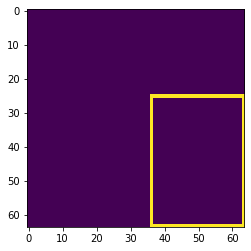

In [7]:
plt.imshow(make_rectangle(image_size))

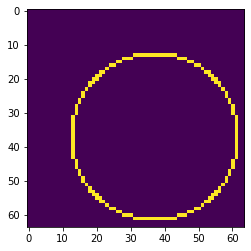

In [8]:
plt.imshow(make_circle(image_size))

### Our generator essentially continiously creates examples

In [9]:
train_generator = Data_Generator(image_size=image_size,batch_size=32, num_examples_per_epoch=150)

In [10]:
x,y = train_generator.__getitem__(0)
print(x.shape)
print(y.shape)

(32, 64, 64, 1)
(32, 2)


## Now lets make our network!

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.python.keras.backend as K
from tensorflow.compat.v1 import Graph, Session, ConfigProto, GPUOptions

### This will make sure multiple networks don't clog up the GPU

In [13]:
def prep_network():
    K.clear_session()
    gpu_options = GPUOptions(allow_growth=True)
    sess = Session(config=ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    K.set_session(sess)
    return None

### Representation of network

![DeepBox_Network.png](./Deep_Learning/DeepBox_Network.png)

### Building the network

In [25]:
prep_network()
num_kernels = 4
kernel_size = (3,3)
model = Sequential([
    Conv2D(num_kernels, kernel_size, 
           input_shape=(image_size, image_size, 1), 
           padding='same',name='Conv_0',activation='sigmoid'),
    MaxPool2D((image_size)), # Pool into a 1x1x4 image
    Flatten(),
    Dense(2,activation='softmax')
])

### Defining loss
#### We are specifying that we care about the categorical cross entropy, with a learning rate of 0.1 (very high)

In [26]:
model.compile(Adam(lr=1e-1), loss='categorical_crossentropy', metrics=['accuracy'])

### Train
#### We give the model our generator, and tell it to run for 5 epochs

In [27]:
model.fit_generator(train_generator,epochs=5)

Epoch 1/5
150/150 [==============================] - 2s 14ms/step - loss: 0.1714 - accuracy: 0.9196

### Evaluate
### We will randomly create 500 examples of rectangles and circles and see how well our model does

In [32]:
def determine_accuracy(model, image_size= 64, num_examples=1000):
    truth = np.zeros((num_examples,1))
    guess = np.zeros((num_examples,1))
    index = 0
    for _ in range(num_examples//2):
        pred = model.predict(make_rectangle(image_size)[None,...,None])
        guess[index] = np.argmax(pred)
        truth[index] = 1
        index += 1
    for _ in range(num_examples//2):
        pred = model.predict(make_circle(image_size)[None,...,None])
        guess[index] = np.argmax(pred)
        index += 1
    print('Accuracy is {} for {} examples'.format(str((guess==truth).sum()/num_examples),num_examples))

In [33]:
determine_accuracy(model)

Accuracy is 1.0 for 1000 examples


### Lets see how confident it is in it's predictions, generate a random circle or rectangle and see what the confidence is

In [35]:
rectangle = make_rectangle(image_size)[None,...,None]
circle = make_circle(image_size)[None,...,None]
print('{}% confident'.format(model.predict(rectangle)[...,1][0]*100))
print('{}% confident'.format(model.predict(circle)[...,0][0]*100))

99.9599039554596% confident
99.55257773399353% confident


## Lets see what the kernels and activations look like

In [36]:
Visualizing_Class = visualization_model_class(model=model)

Conv_0
max_pooling2d
flatten
dense


### Say that we only want to look at Conv_0

In [37]:
Visualizing_Class.define_desired_layers(desired_layer_names=['Conv_0'])

## Kernels

Conv_0


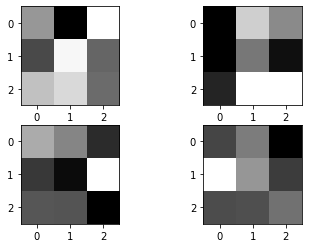

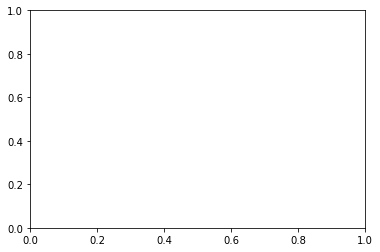

In [38]:
Visualizing_Class.plot_kernels()

## Activations
### In order to make an activation map we need to provide it with something to predict on

In [39]:
Visualizing_Class.predict_on_tensor(make_rectangle(image_size)[None,...,None])

['Conv_0']
Conv_0
0.0


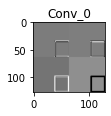

In [40]:
Visualizing_Class.plot_activations()

## How big is this model? Super tiny!!

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_0 (Conv2D)              (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 2)                 10        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


# Data curation

### Import some necessary functions

In [1]:
import os
def return_sys_path():
    path = '.'
    for _ in range(5):
        if 'Pre_Processing' in os.listdir(path):
            break
        else:
            path = os.path.join(path,'..')
    return path
def return_data_path():
    path = '.'
    for _ in range(5):
        if 'Data' in os.listdir(path):
            break
        else:
            path = os.path.join(path,'..')
    return path

In [2]:
import sys
sys.path.append(return_sys_path())
from Pre_Processing.Distribute_Patients import Separate_files
from Pre_Processing.Dicom_RT_and_Images_to_Mask.Image_Array_And_Mask_From_Dicom_RT import Dicom_to_Imagestack
from Pre_Processing.Dicom_RT_and_Images_to_Mask.Plot_And_Scroll_Images.Plot_Scroll_Images import plot_Image_Scroll_Bar_Image

## Finding the Data

### Find where we put our data

In [4]:
data_path = os.path.join(return_data_path(),'Data','Whole_Patients')
print('We have ' + str(len(os.listdir(data_path))) + ' patients!')

We have 20 patients!


## Ensuring contour fidelity...

### Note that we've set 'get_images_mask' to False, this means we won't be getting any of the image data, just looking at the dicom RT files

In [5]:
Dicom_Reader = Dicom_to_Imagestack(get_images_mask=False)

In [6]:
Dicom_Reader.down_folder(data_path)

### What ROI names do we have?

#### This will tell us all the unique roi names, hence all_rois

In [6]:
for roi in Dicom_Reader.all_rois:
    print(roi)

bma_liver
Liver_BMA_Program_4
tried_liver
best_liver
Liver


## Make contour associations

#### We have quite a few contour names here.. now, we can either change the ROI names in the RT files, or make an associations file

#### The associations file associates a contour name with another one {'Current contour':'Desired name'}

In [7]:
associations = {'Liver_BMA_Program_4':'Liver',
                'bma_liver':'Liver',
                'best_liver':'Liver',
                'tried_liver':'Liver'}

### Tell the Dicom_Reader that we want to set the associations, get the images and mask for contour 'Liver'

In [8]:
Dicom_Reader.set_associations(associations)
Dicom_Reader.set_get_images_and_mask(True)
Dicom_Reader.set_contour_names(['liver'])

### Re-write RTs
#### This is commented out, because if I run it, then the example above won't show any different contour names

In [ ]:
# Dicom_Reader.associations = associations
# for RT in Dicom_Reader.all_RTs:
#     Dicom_Reader.rewrite_RT(RT)

## Pulling images and mask

### We'll first do this with one patient

In [9]:
patient_data_path = os.path.join(data_path,'ABD_LYMPH_036')
Dicom_Reader.Make_Contour_From_directory(patient_data_path)
print('Done!')

Done!


## View images

In [ ]:
%matplotlib inline

### The images and mask are saved within the Dicom_Reader class, so we just have to load them

In [ ]:
Images = Dicom_Reader.ArrayDicom
mask = Dicom_Reader.mask # This is the mask

#### Threshold

In [ ]:
Images[Images<-200] = -200
Images[Images>200] = 200

In [ ]:
plot_Image_Scroll_Bar_Image(Images)

In [ ]:
Images[mask==1] += 300

## Recap

### Checking ROI contour names and making associations

### Loading in image and mask from desired contour name

### Viewing images and mask

## Separate into Train/Test/Validation

### This is also important, but I would recommend using the .write_parallel function
### This will create the niftii files and randomly separate them into Train/Validation/Test folders

In [9]:
desc = 'TCIA_Liver_Patients'
output_path = data_path.replace('Whole_Patients','Niftii_Arrays')
Dicom_Reader.set_get_images_and_mask(False)
Dicom_Reader.set_description(desc)
Dicom_Reader.down_folder(data_path,reset=True)
# Dicom_Reader.write_parallel(output_path,excel_file=os.path.join('.','patient_dist.xlsx'), thread_count=10)
# Separate_files(input_path=os.path.join(output_path,desc), out_path=output_path)

.\..\..\Data\Whole_Patients\ABD_LYMPH_007.\..\..\Data\Whole_Patients\ABD_LYMPH_016
.\..\..\Data\Whole_Patients\ABD_LYMPH_019
.\..\..\Data\Whole_Patients\ABD_LYMPH_028

.\..\..\Data\Whole_Patients\ABD_LYMPH_033.\..\..\Data\Whole_Patients\ABD_LYMPH_036

.\..\..\Data\Whole_Patients\ABD_LYMPH_069.\..\..\Data\Whole_Patients\MED_LYMPH_002

.\..\..\Data\Whole_Patients\MED_LYMPH_017.\..\..\Data\Whole_Patients\MED_LYMPH_024

.\..\..\Data\Whole_Patients\MED_LYMPH_029
.\..\..\Data\Whole_Patients\MED_LYMPH_030
.\..\..\Data\Whole_Patients\MED_LYMPH_044
.\..\..\Data\Whole_Patients\MED_LYMPH_055
.\..\..\Data\Whole_Patients\MED_LYMPH_063
.\..\..\Data\Whole_Patients\MED_LYMPH_064
.\..\..\Data\Whole_Patients\MED_LYMPH_067
.\..\..\Data\Whole_Patients\MED_LYMPH_069
.\..\..\Data\Whole_Patients\MED_LYMPH_073.\..\..\Data\Whole_Patients\MED_LYMPH_075



## Turn into TFRecords

In [10]:
from Pre_Processing.Make_Single_Images.Make_TFRecord_Class import write_tf_record
from Pre_Processing.Make_Single_Images.Image_Processors_Module.Image_Processors_TFRecord import *
image_processors = [To_Categorical(),
                    Cast_Data({"image":"float16",'annotation':'int8'}),
                    Distribute_into_2D()]
path = data_path.replace('Whole_Patients','Niftii_Arrays')
# write_tf_record(os.path.join(path, 'Train'), out_path=os.path.join(path,'Records','Train'), image_processors=image_processors,
#                 is_3D=False, verbose=False, thread_count=14)
image_processors = [To_Categorical(),
                    Cast_Data({"image":"float16",'annotation':'int8'}),
                    Distribute_into_3D()]
# write_tf_record(os.path.join(path, 'Validation'), out_path=os.path.join(path,'Records','Validation'), image_processors=image_processors,
#                 is_3D=True, thread_count=3)
image_processors = [To_Categorical(),
                    Cast_Data({"image":"float16",'annotation':'int8'}),
                    Distribute_into_3D()]
# write_tf_record(os.path.join(path, 'Test'), out_path=os.path.join(path,'Records','Test'), image_processors=image_processors,
#                 is_3D=True, thread_count=3)

.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_0.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_1.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_10.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_11.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_12.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_14.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_15.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_18.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_19.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_2.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_3.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_4.nii.gz
.\..\..\Data\Niftii_Arrays\Train\Overall_Data_TCIA_Liver_Patients_6.nii.gz
.\..\..\Data\Nifti

# Liver Model

## Import some things

In [ ]:
def return_sys_path():
    path = '.'
    for _ in range(5):
        if 'Deep_Learning' in os.listdir(path):
            break
        else:
            path = os.path.join(path,'..')
    return path
def return_data_path():
    path = '.'
    for _ in range(5):
        if 'Data' in os.listdir(path):
            break
        else:
            path = os.path.join(path,'..')
    return path

In [ ]:
import os, sys
sys.path.append(return_sys_path())
from Deep_Learning.Base_Deeplearning_Code.Data_Generators.TFRecord_to_Dataset_Generator import *
from Deep_Learning.Base_Deeplearning_Code.Callbacks.TF2_Callbacks import Add_Images_and_LR
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from Deep_Learning.Base_Deeplearning_Code.Plot_And_Scroll_Images.Plot_Scroll_Images import plot_Image_Scroll_Bar_Image
import tensorflow as tf
import tensorflow.keras.backend as K

In [ ]:
%matplotlib inline

In [ ]:
%load_ext tensorboard

In [ ]:
base = return_sys_path()
data_path = os.path.join(return_data_path(),'Data','Niftii_Arrays','Records')
train_path = [os.path.join(data_path,'Train')]
validation_path = [os.path.join(data_path,'Validation')]
test_path = os.path.join(data_path,'Test')
model_path = os.path.join(base,'Models')
if not os.path.exists(model_path):
    os.makedirs(model_path)

## We now need some image processors...

#### We will ensure that the images are 256 x 256 (downsampled for speed), normalize them with a mean of 78 and std of 29, add random noise, threshold, and turn into 2 classes

In [ ]:
image_size = 128
wanted_keys={'inputs':['image'],'outputs':['annotation']}
image_processors_train = [Expand_Dimensions(axis=-1),
                          Ensure_Image_Proportions(image_size,image_size),
                          Repeat_Channel(repeats=3),
                          Normalize_Images(mean_val=78,std_val=29),
                          Threshold_Images(lower_bound=-3.55,upper_bound=3.55),
                          Return_Outputs(wanted_keys)]
image_processors_validation = [Expand_Dimensions(axis=-1),
                          Ensure_Image_Proportions(image_size,image_size),
                          Repeat_Channel(repeats=3),
                          Normalize_Images(mean_val=78,std_val=29),
                          Threshold_Images(lower_bound=-3.55,upper_bound=3.55),
                          Return_Outputs(wanted_keys)]

In [ ]:
batch_size = 5
train_generator = Data_Generator_Class(record_paths=train_path)
validation_generator = Data_Generator_Class(record_paths=validation_path)
image_processors_train += [
            {'shuffle': len(train_generator)}, {'batch': batch_size}, {'repeat'}]
image_processors_validation += [{'repeat'}]
train_generator.compile_data_set(image_processors_train)
validation_generator.compile_data_set(image_processors_validation)


### Lets visualize one of the examples! With batch_size of 5 and shuffle on, it will be 5 random 2D slices

In [ ]:
x,y = next(iter(train_generator.data_set))
x = x[0].numpy()
y = y[0].numpy()

In [ ]:
plot_Image_Scroll_Bar_Image(x)

In [ ]:
plot_Image_Scroll_Bar_Image(np.argmax(y,axis=-1))

### Alright, lets make our model!

In [ ]:
from Deep_Learning.Easy_VGG16_UNet.Keras_Fine_Tune_VGG16_TF2 import VGG_16
from Deep_Learning.Base_Deeplearning_Code.Visualizing_Model.Visualing_Model import visualization_model_class
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1 import GPUOptions, ConfigProto, Session
from tensorflow.python.keras.backend import set_session
from Deep_Learning.Base_Deeplearning_Code.Callbacks.TF2_Callbacks import MeanDSC

### This is just a click and play, it builds the VGG16 architecture for you with pre-trained weights

![VGG16_Unet.png](./Deep_Learning/Easy_VGG16_UNet/VGG16_UNet.png)

In [ ]:
K.clear_session()
gpu_options = GPUOptions(allow_growth=True)
sess = Session(config=ConfigProto(gpu_options=gpu_options, log_device_placement=False))
set_session(sess)
network = {'Layer_0': {'Encoding': [64, 64], 'Decoding': [64]},
           'Layer_1': {'Encoding': [128, 128], 'Decoding': [64]},
           'Layer_2': {'Encoding': [256, 256, 256], 'Decoding': [256]},
           'Layer_3': {'Encoding': [512, 512, 512], 'Decoding': [256]},
           'Layer_4': {'Encoding': [512, 512, 512]}}
VGG_model = VGG_16(network=network, activation='relu',filter_size=(3,3))
VGG_model.make_model()
VGG_model.load_weights()
new_model = VGG_model.created_model
model_path = os.path.join(return_sys_path(),'Models')

## These are some tools for visualizing the model

In [ ]:
Visualizing_Class = visualization_model_class(model=new_model, save_images=True, verbose=True)

### Lets look at the activations of block1_conv1, the activation, and output

In [ ]:
Visualizing_Class.define_desired_layers(['block1_conv1','block1_conv1_activation','Output'])

In [ ]:
Visualizing_Class.predict_on_tensor(x[0,...][None,...])

In [ ]:
Visualizing_Class.plot_activations()

## Freezing pre-trained layers

In [ ]:
new_model.compile(tf.keras.optimizers.Adam(5e-5), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(), MeanDSC(num_classes=2)])

In [ ]:
def freeze_until_name(model,name):
    set_trainable = False
    for layer in model.layers:
        if layer.name == name:
            set_trainable = True
        layer.trainable = set_trainable
    return model
new_model = freeze_until_name(new_model,'Upsampling0_UNet')

## Checkpoint and run

A checkpoint is a way of assessing the model and determining if we should save it

In [ ]:
model_name = 'VGG_16_Model'
model_path_out = os.path.join(model_path,'VGG_16_frozen')
if not os.path.exists(model_path_out):
    os.makedirs(model_path_out)

In [ ]:
checkpoint = ModelCheckpoint(os.path.join(model_path_out,'cp-best.ckpt'), monitor='val_mean_dsc', verbose=1, save_best_only=True,
                              save_weights_only=True, mode='max')

add_images = Add_Images_and_LR(log_dir=model_path_out, validation_data=validation_generator.data_set,
                               number_of_images=len(validation_generator), add_images=True, image_frequency=3,
                               threshold_x=True, target_image_height=128, target_image_width=128)
tensorboard = TensorBoard(log_dir=model_path_out)
callbacks = [checkpoint, tensorboard, add_images]

### Lets view the model real quick

In [ ]:
k = TensorBoard(model_path_out)
k.set_model(new_model)

In [ ]:
%tensorboard --logdir {"./Models"}

### Lets train!

In [ ]:
new_model.fit(train_generator.data_set, epochs=5, callbacks=callbacks, steps_per_epoch=len(train_generator),
              validation_data=validation_generator.data_set, validation_steps=len(validation_generator),
              validation_freq=1)

In [ ]:
x,y = next(iter(validation_generator.data_set))

In [ ]:
pred = new_model.predict(x)

In [ ]:
pred[pred<0.5] = 0
pred[pred>0] = 1

In [ ]:
plot_Image_Scroll_Bar_Image(pred[...,1])

# Now lets make our own architecture

### First, lets import some necessary functions

In [ ]:
from Deep_Learning.Base_Deeplearning_Code.Models.TF_Keras_Models import my_UNet, Return_Layer_Functions, return_hollow_layers_dict
from Deep_Learning.Base_Deeplearning_Code.Cyclical_Learning_Rate.clr_callback_TF2 import CyclicLR
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

### Define our convolution and strided blocks, strided is used for downsampling

In [ ]:
activation = {'activation': 'relu'}
kernel = (3,3)
pool_size = (2,2)
#{'channels': x, 'kernel': (3, 3), 'strides': (1, 1),'activation':activation}
conv_block = lambda x: {'convolution': {'channels': x, 'kernel': (3, 3),
                                        'activation': None, 'strides': (1, 1)}}
pooling_downsampling = {'pooling': {'pooling_type': 'Max',
                                    'pool_size': (2, 2), 'direction': 'Down'}}
pooling_upsampling = {'pooling': {'pool_size': (2, 2), 'direction': 'Up'}}

### Our architecture will have 2 main parts in each layer, an 'Encoding' and a 'Decoding' side, 'Encoding' goes down, and 'Decoding' goes up

![Encoding and Decoding.png](./Deep_Learning/Encoding_and_Decoding.png)

### We will now create our layer dictionary, this tells our UNet what to look like

### If Pooling is left {} it will perform maxpooling and upsampling with pooling()

In [ ]:
layers_dict = {}
lc = Return_Layer_Functions(kernel=(3,3),strides=(1,1),padding='same',batch_norm=True,
                                pooling_type='Max', pool_size=(2,2), bn_before_activation=False)
conv_block = lc.convolution_layer
layers_dict['Layer_0'] = {'Encoding': [conv_block(8),conv_block(8)],
                          'Decoding': [conv_block(16), conv_block(16)],
                          'Pooling':
                              {'Encoding': [lc.convolution_layer(16, strides=(2, 2))],
                               'Decoding': [lc.upsampling_layer(pool_size=(2, 2)),
                                       lc.convolution_layer(16)]
                               }}
layers_dict['Base'] = [conv_block(16), conv_block(16)]
layers_dict['Final_Steps'] =  [lc.convolution_layer(16, batch_norm=True, kernel=(1, 1),activation='elu'),
                               lc.convolution_layer(2, batch_norm=False, activation='softmax')]

In [ ]:
layers_dict['Layer_0'] = {'Encoding': [conv_block(16),activation,conv_block(16),activation],
                          'Decoding': [conv_block(32),activation,conv_block(32),activation],
                          'Pooling':
                              {'Encoding': [pooling_downsampling],
                               'Decoding': [pooling_upsampling]
                               }}
layers_dict['Base'] = [conv_block(32),activation,conv_block(32),activation]
layers_dict['Final_Steps'] = [conv_block(2),{'activation':'softmax'}]

In [ ]:
K.clear_session()
gpu_options = GPUOptions(allow_growth=True)
sess = Session(config=ConfigProto(gpu_options=gpu_options, log_device_placement=False))
set_session(sess)
new_model = my_UNet(layers_dict=layers_dict, image_size=(128, 128, 3), is_2D=True).created_model

### Name your model and define other things! Send a list of strings and it will make a folder path

In [ ]:
model_name = 'My_New_Model'
model_path_out = os.path.join(model_path,model_name)
if not os.path.exists(model_path_out):
    os.makedirs(model_path_out)

### Lets look at our model

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
k = TensorBoard(model_path_out)
k.set_model(new_model)

In [ ]:
%tensorboard --logdir {"./Models"}

### Set a learning rate and loss metric, also add any metrics you want to track

In [ ]:
min_lr = 5e-6
max_lr = 1e-3
new_model.compile(tf.keras.optimizers.Adam(5e-5), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(), MeanDSC(num_classes=2)])

### This is a checkpoint to save the model if it has the highest dice, also to add images

#### We will specify that we want to watch the validation dice, and save the one with the highest value

In [ ]:
monitor = 'val_mean_dsc'
mode = 'max'
checkpoint = ModelCheckpoint(os.path.join(model_path_out,'cp-best.ckpt'), monitor=monitor, verbose=1, save_best_only=True,
                             save_weights_only=True, save_freq='epoch', mode=mode)

#### Next, our tensorboard output will add prediction images


#### CyclicLR will allow us to change the learning rate of the model as it runs, and Add_LR_To_Tensorboard will let us view it later

In [ ]:
steps_per_epoch = len(train_generator)//3
step_size_factor = 10

cyclic_lrate = CyclicLR(base_lr=min_lr, max_lr=max_lr, step_size=steps_per_epoch * step_size_factor, mode='triangular2')
checkpoint = ModelCheckpoint(os.path.join(model_path_out,'cp-best.ckpt'), monitor=monitor, verbose=1, save_best_only=True,
                              save_weights_only=False, mode='max')

add_images = Add_Images_and_LR(log_dir=model_path_out, validation_data=validation_generator.data_set,
                               number_of_images=len(validation_generator), add_images=True, image_frequency=3
                               threshold_x=True, target_image_height=128, target_image_width=128)
tensorboard = TensorBoard(log_dir=model_path_out)

### Combine all callbacks

In [ ]:
callbacks = [cyclic_lrate, checkpoint, tensorboard, add_images]

In [ ]:
new_model.fit(train_generator.data_set, epochs=5, callbacks=callbacks, steps_per_epoch=len(train_generator),
              validation_data=validation_generator.data_set, validation_steps=len(validation_generator),
              validation_freq=1)

In [ ]:
%tensorboard --logdir {"./Models"}